In [89]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
import matplotlib as mpl

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


In [4]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'is_scd_outlier', 'mean', 'std', 'gene_mean', 'gene_var', 'mean_var_diff', 'gene_dist', 'est_mean', 'est_overdisp', 'est_zero_inflation'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'd

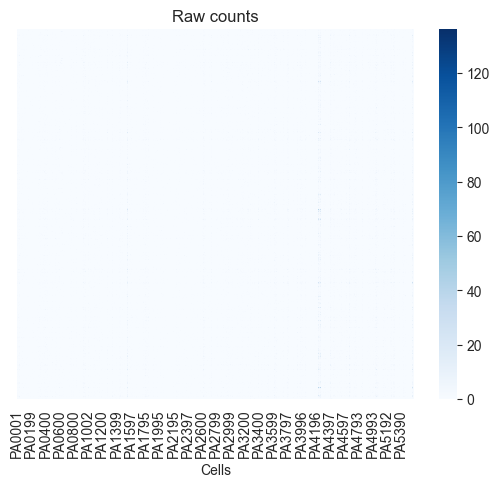

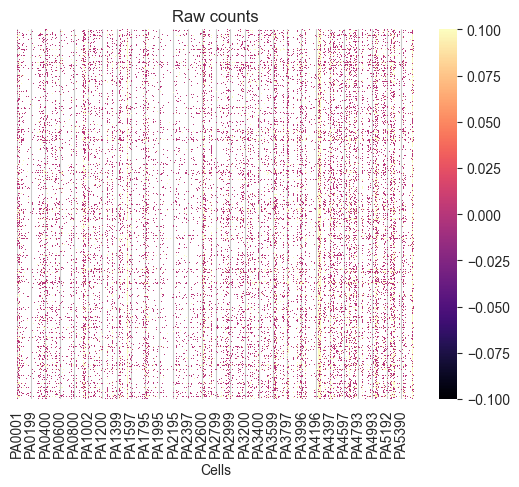

In [57]:
sns.heatmap(pd.DataFrame(data_gene.layers["counts"].toarray(), index=data_gene.obs_names, columns=data_gene.var_names), cmap="Blues")

plt.yticks([], [])
plt.xlabel("Genes")
plt.xlabel("Cells")
plt.title("Raw counts")

plt.show()

sns.heatmap(pd.DataFrame(np.log(data_gene.layers["counts"].toarray()), index=data_gene.obs_names, columns=data_gene.var_names), cmap="magma")

plt.yticks([], [])
plt.xlabel("Genes")
plt.xlabel("Cells")
plt.title("Raw counts")

plt.show()

PAO1_ID               PA0001    PA0002    PA0003    PA0004    PA0005  \
AAACCCAGTGGACCTC-1 -0.770344 -0.603808 -0.917575 -0.548531 -0.315008   
GAGTGTTGTTGATGTC-1  1.855752 -0.603808 -0.917575  4.124194 -0.315008   
GAGTTACTCAATCCGA-1  1.654359 -0.603808 -0.917575 -0.548531 -0.315008   
GATAGAAAGAGAGGTA-1 -0.770344 -0.603808 -0.917575 -0.548531 -0.315008   
GATAGAACAAGCGAGT-1  4.157748 -0.603808  1.615339 -0.548531 -0.315008   
...                      ...       ...       ...       ...       ...   
GTGCTTCTCACCCTCA-1 -0.770344  1.228863 -0.917575 -0.548531 -0.315008   
TGCAGGCGTTCAAACC-1 -0.770344 -0.603808  0.558563 -0.548531 -0.315008   
CCTAACCTCTCATGGA-1  1.031707 -0.603808 -0.917575 -0.548531 -0.315008   
AGGCTGCGTAGCGTTT-1 -0.770344 -0.603808  1.283274 -0.548531 -0.315008   
ATGGATCCATTAGGAA-1  1.703292 -0.603808  1.301909  1.275221 -0.315008   

PAO1_ID               PA0006    PA0007    PA0008    PA0009    PA0010  ...  \
AAACCCAGTGGACCTC-1 -0.404776 -0.225185 -0.684304 -0.584912

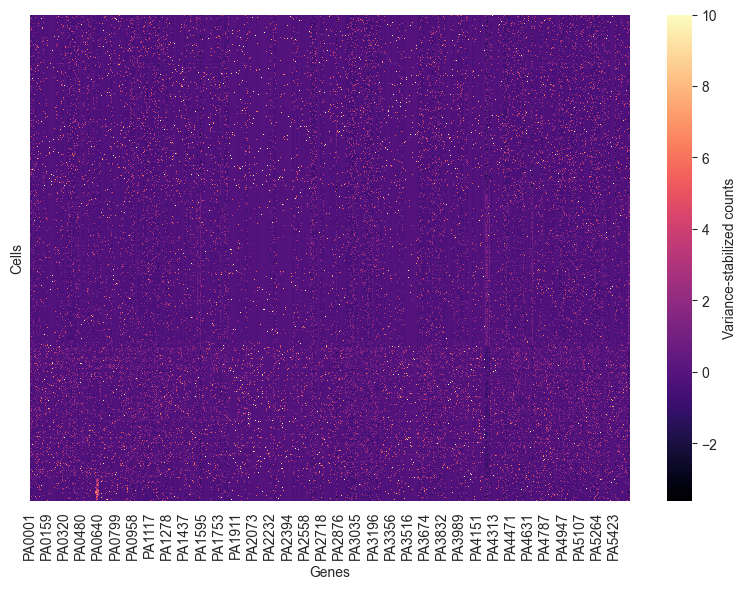

In [189]:
plt.figure(figsize=(8, 6))
data_heatmap = pd.DataFrame(data_gene.X, index=data_gene.obs_names, columns=data_gene.var_names)
data_heatmap["ct"] = data_gene.obs["leiden_opt"]
data_heatmap = data_heatmap.sort_values("ct")
data_heatmap = data_heatmap.drop(columns="ct")
print(data_heatmap)

sns.heatmap(data_heatmap, cmap="magma", cbar_kws={'label': 'Variance-stabilized counts'})
plt.yticks([], [])
plt.xlabel("Genes")
plt.ylabel("Cells")
# plt.title("Variance-stabilized counts")

plt.tight_layout()
# plt.savefig("/Users/johannes.ostner/Documents/PhD/Bacterial_single_cell_paper/figures/vst_heatmap.png", format="png")
plt.show()

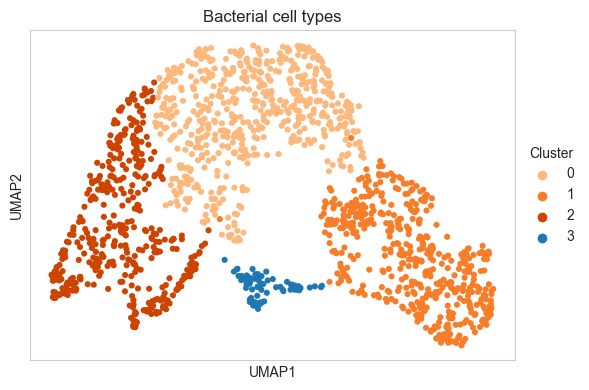

In [102]:
with plt.rc_context({"figure.figsize": (6, 4)}):
    
    colors = mpl.colormaps['Oranges'](np.linspace(0, 1, 10))
    fig = sc.pl.umap(data_gene, color="leiden_opt", palette=[colors[3], colors[5], colors[7], "tab:blue"], title="Bacterial cell types", show=False)
    ax = fig.axes
    ax.legend_.set_title("Cluster")
    plt.tight_layout()
    
    plt.savefig("/Users/johannes.ostner/Documents/PhD/Bacterial_single_cell_paper/figures/cluster_umap.svg", format="svg")
    
    plt.show()

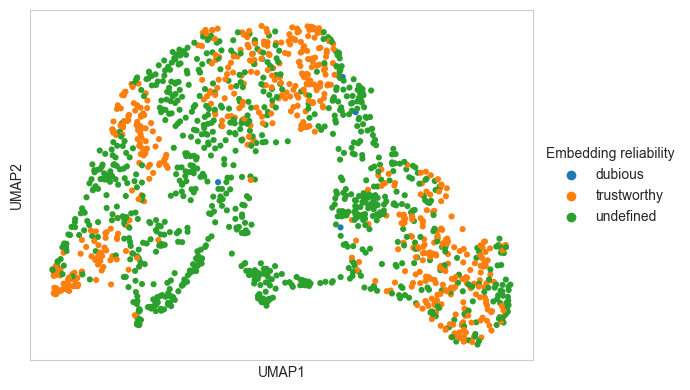

In [34]:
with plt.rc_context({"figure.figsize": (7, 4)}):

    fig = sc.pl.umap(data_gene, color="embedding_reliability", alpha=1, show=False, title="")
    ax = fig.axes
    ax.legend_.set_title("Embedding reliability")
    
    
    plt.tight_layout()
    plt.savefig("/Users/johannes.ostner/Documents/PhD/Bacterial_single_cell_paper/figures/reliability_umap.svg", format="svg")
    plt.show()

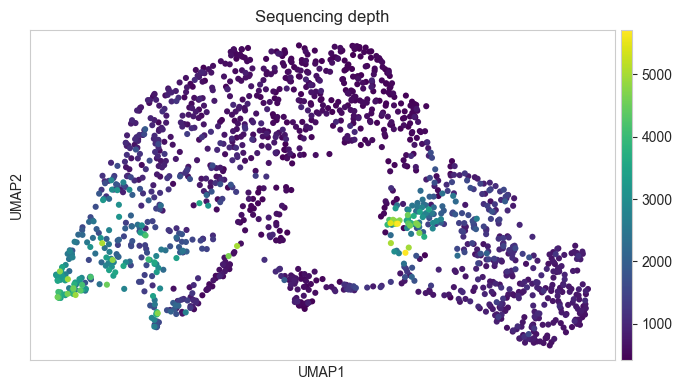

In [120]:
with plt.rc_context({"figure.figsize": (7, 4)}):

    fig = sc.pl.umap(data_gene, color="total_counts", alpha=1, show=False, title="Sequencing depth", cmap="viridis")
    ax = fig.axes
    # ax.legend_.set_title("Embedding reliability")
    
    
    plt.tight_layout()
    plt.savefig("/Users/johannes.ostner/Documents/PhD/Bacterial_single_cell_paper/figures/seq_depth_umap.svg", format="svg")
    plt.show()

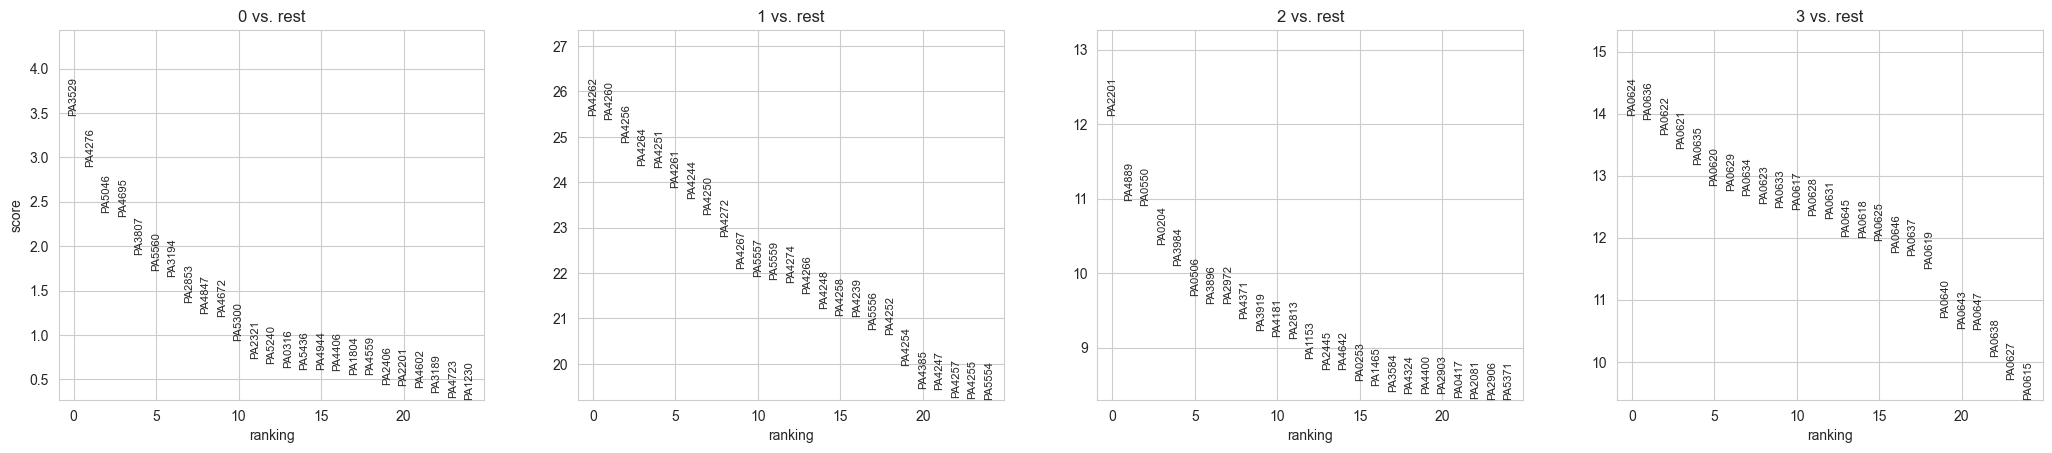

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA0636,6.161842e-44,3.302838e-02,43.210289,1.481113,41.729177,0.25
PA0622,1.946223e-42,2.182819e-02,41.710807,1.660982,40.049825,0.25
PA0624,2.354790e-44,9.053055e-05,43.628048,4.043205,39.584843,0.25
PA0621,4.073517e-41,1.895977e-03,40.390030,2.722167,37.667863,0.25
PA0635,1.254658e-39,2.739059e-03,38.901475,2.562399,36.339076,0.25
...,...,...,...,...,...,...
PA1074,2.382140e-01,1.081838e-28,0.623033,27.965838,-27.342805,1.00
PA5049,4.892274e-01,9.830930e-31,0.310489,30.007405,-29.696916,1.00
PA4672,7.288135e-01,2.717943e-34,0.137384,33.565760,-33.428376,1.00


In [39]:
pvals_log_gen = pd.read_csv("../test/pvals_3.csv", index_col=0)
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)
pvals_log_gen

16


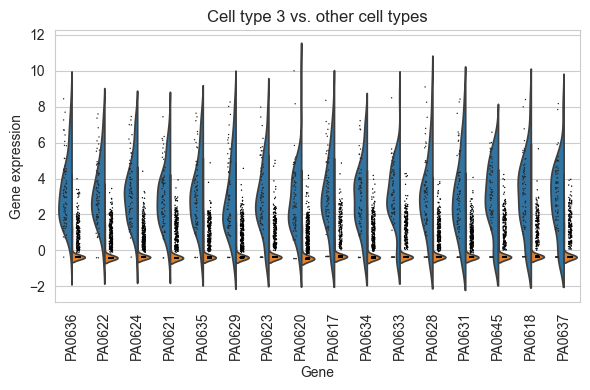

In [192]:
n_25 = np.sum(pvals_log_gen["q"] <= 0.25)
print(n_25)
with plt.rc_context({"figure.figsize": (6, 4)}):

    sc.pl.rank_genes_groups_violin(data_gene, groups="3", gene_names=pvals_log_gen.sort_values("q", ascending=True).index.tolist()[:n_25], show=False)
    plt.ylabel("Gene expression")
    plt.xlabel("Gene")
    plt.title("Cell type 3 vs. other cell types")
    
    plt.tight_layout()
    plt.savefig("/Users/johannes.ostner/Documents/PhD/Bacterial_single_cell_paper/figures/cluster_3_violin.svg", format="svg")
    plt.show()

In [60]:
print(data_gene.layers["counts"].toarray()[:4,:])

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 7. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 6. 0.]]


In [75]:

pca_df = pd.DataFrame(data_gene.obsm["X_pca"], index=data_gene.obs_names)

<Axes.ArtistList of 0 images>


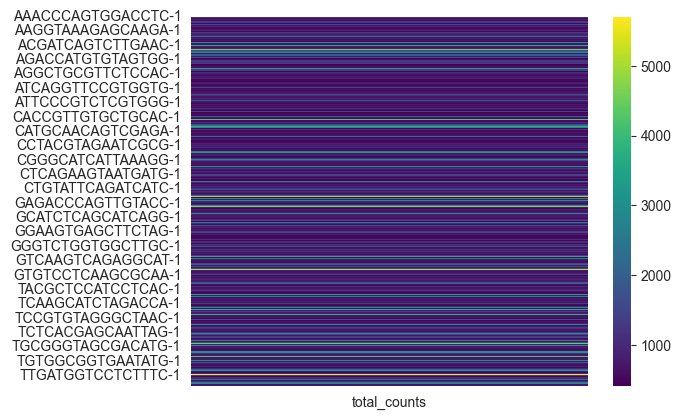

In [155]:
f, ax = plt.subplots()
sns.heatmap(data_gene.obs.loc[:, ["total_counts"]], cmap="viridis", ax=ax)
cbar_ax = f.axes[-1]

In [156]:
print(cbar_ax)

Axes(0.78375,0.11;0.028875x0.77)


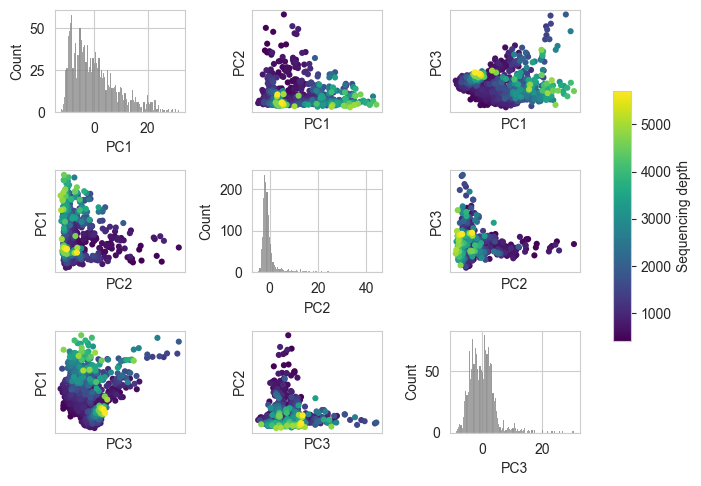

In [187]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 5))
cbar_ax = fig.add_axes([1.03, .3, .03, .5])

sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(0,1), ax=ax[0, 1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(1, 0), ax=ax[1,0], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(1,2), ax=ax[1,2], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(2,1), ax=ax[2,1], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(0,2), ax=ax[0,2], title="", show=False, colorbar_loc=None)
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", dimensions=(2,0), ax=ax[2,0], title="", show=False, colorbar_loc=None)

sns.histplot(pca_df, x=0, ax=ax[0,0], color="dimgrey", bins=100)
ax[0,0].set(xlabel="PC1")
sns.histplot(pca_df, x=1, ax=ax[1,1], color="dimgrey", bins=100)
ax[1,1].set(xlabel="PC2")
sns.histplot(pca_df, x=2, ax=ax[2,2], color="dimgrey", bins=100)
ax[2,2].set(xlabel="PC3")

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(np.min(data_gene.obs["total_counts"]), np.max(data_gene.obs["total_counts"]))  # or vmin, vmax
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), cbar_ax)
cbar.set_label('Sequencing depth')

plt.tight_layout()
plt.savefig("/Users/johannes.ostner/Documents/PhD/Bacterial_single_cell_paper/figures/pca_grid.svg", format="svg", bbox_inches="tight")

plt.show()

In [170]:
np.max(data_gene.obs["total_counts"])

5704.0